<h1><center>Plan</center></h1>

| <h2>Classification</h2> | <h2>Regression</h2> | <h2>Clustering</h2> |
| :- | :- | :- |
| Neural network (MLP) DONE | Decision tree (LightGBM) DONE | PCA and k-means DONE |
| Decision tree (LightGBM) DONE | Neural network (MLP) DONE |  |
| kNN DONE| kNN DONE |  |



# Load the training data

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [3]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        return pd.DataFrame(f[name][:])

train = load_data('train')

#only consider actual electrons
electrons = train[train['Truth'] == True]

#only use 6 best features (curse of dimensionality)
best_features = ['p_eCluster',
 'p_eAccCluster',
 'p_ecore',
 'p_E3x5_Lr1',
 'p_rawECluster',
 'p_nCells_Lr1_HiG']

train_variables = electrons[best_features]
train_energy = electrons['p_truth_E']
train_class = electrons['Truth']

#scale data
transformer = RobustScaler().fit(train_variables)
train_variables = pd.DataFrame(transformer.transform(train_variables), columns=train_variables.columns
)

# Regression

### kNN (SciKit-learn)

In [4]:
#define error function
def mape(pred, true):
    diffs = abs((true-pred)/true)
    
    return (sum(diffs))/len(pred)

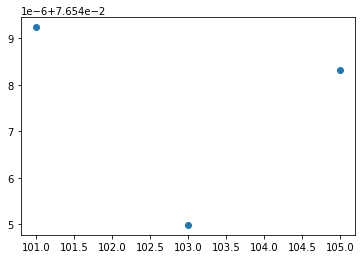

In [14]:
#find optimal k
from sklearn.neighbors import KNeighborsRegressor as kNN
from sklearn.model_selection import KFold

ks = [101,103,105]
k_error = []
for k in ks: 
    fold_error = []
    
    cv = KFold(n_splits=10)
    for train_index, validation_index in cv.split(train_variables.to_numpy()):
        
        #define training and validation sets for each fold
        x_trainCV, x_valCV, y_trainCV, y_valCV = train_variables.to_numpy()[train_index], train_variables.to_numpy()[validation_index], train_energy.to_numpy()[train_index], train_energy.to_numpy()[validation_index]

        #train kNN model on training set
        neigh = kNN(n_neighbors=k)
        neigh.fit(x_trainCV, y_trainCV)
        
        #append accuracy for each fold
        y_pred = neigh.predict(x_valCV)
        error = mape(y_pred, y_valCV)
        fold_error.append(error)
   
    #append mean accuracy for each leaf number    
    k_error.append(np.mean(fold_error))
    
plt.scatter(ks, k_error)
plt.show()

#103 seems to be the best k

In [15]:
#use optimal k 
x_train, x_val, y_train, y_val = train_test_split(train_variables, train_energy, test_size=0.3, random_state=42)

neigh = kNN(n_neighbors=103)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_val)
error = mape(y_pred, y_val)
print('kNN MAPE:'+str(error))

kNN MAPE:0.07990859732720648


# Test data

In [6]:
#load test set
test = load_data('test')
test_variables = test[best_features]

#scale test data
transformer = RobustScaler().fit(test_variables)
test_variables = pd.DataFrame(transformer.transform(test_variables), columns=test_variables.columns
)

In [8]:
#use model on test data
y_pred = pd.DataFrame(neigh.predict(test_variables))

#export to csv
# y_pred.to_csv('predicted_energies_kNN.csv', header=False)